# TIØ4317 - Empirical and Quantitative Methods in Finance Project 

## Group 20

|Name|Student ID|Student mail|
|----|----------|------------|
|Synne Råheim Borge|564397|synnerbo@stud.ntnu.no|
|Tallak Ravn|544531|tallakr@stud.ntnu.no|
|Thomas Heggø Teigland|544530|thomaht@stud.ntnu.no|
|Torstein Johnsrud|564296|torstjo@stud.ntnu.no

## Problem statement

Our initial thoughts and hypothesis are based on the assumption that the price ratio between Bitcoin and Bitcoin cash should indeed remain stable over time. This is due to their shared origin and technological similarities. Market fluctuations may cause temporary deviations, but our hypothesis is that the fundamental value drivers and arbitrage traders should contribute to the price levels returning to this proposed equilibrium. Furthermore, our guess is that the case of a diverging ratio would create an opportunity for strategic betting on reversion to the expected value. More specifically, going long in the proposed undervalued asset and short in the overvalued one would create the opportunity for earning a return given that the market forces will correct the deviation over time. This assumes no fundamental market shift altering the balance between the currencies.

This approach however, does not take into account the possibility for an inter-market arbitrage within the respective assets. Specifically, there exists a possibility for the individual assets to be priced differently in different markets, creating room for arbitrage only taking positions in BTC, or alternatively, BCH. Our project has narrowed it down to exclude this prospect.

Pairs trading relies on identifying assets that maintain a stable long-term relationship, which can be assessed using techniques like the Engle-Granger two-step method or the Johansen test for cointegration. The strategy assumes that deviations from this equilibrium are temporary and will revert over time. Autoregressive Integrated Moving Average (ARIMA) model can be applied to predict spread movements and optimize trading signals.

The group wants to see whether a simple mean-reverting pairs trading strategy generate consistent profits in cryptocurrency markets?

## Data
The data for this project was sourced using the Python library “yfinance”. By calling the ticker symbols for Bitcoin and Bitcoin Cash, "BTC-USD" and "BCH-USD", respectively, we obtained data frames containing various columns, including the date, and closing price.  

Before proceeding with the analysis, we conducted an initial inspection to verify data integrity and check for missing values or outliers. However, no inconsistencies were found. Additionally, plotting the closing prices produced reasonable graphs, indicating that the data was clean and ready for further empirical analysis.

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import statsmodels.api as sm

In [170]:
np.random.seed(25)

In [156]:
ticker_Bitcoin = yf.Ticker("BTC-USD")  
df_Bitcoin = ticker_Bitcoin.history(period="5y")  

ticker_Bitcoin_Cash = yf.Ticker("BCH-USD")  
df_Bitcoin_Cash = ticker_Bitcoin_Cash.history(period="5y")  


In [157]:
# Data cleaning for Bitcoin
print("Datafile head: \n", df_Bitcoin.head())       
print("Checking for null values:")       
print( df_Bitcoin.info())
print("Statistical precentiles: \n", df_Bitcoin.describe())


Datafile head: 
                                   Open         High          Low        Close  \
Date                                                                            
2020-04-04 00:00:00+00:00  6738.382812  6878.953613  6696.484863  6867.527344   
2020-04-05 00:00:00+00:00  6862.537598  6883.414062  6715.929199  6791.129395   
2020-04-06 00:00:00+00:00  6788.049805  7271.781250  6782.889648  7271.781250   
2020-04-07 00:00:00+00:00  7273.644043  7427.939453  7136.714355  7176.414551   
2020-04-08 00:00:00+00:00  7179.283203  7356.223633  7153.305664  7334.098633   

                                Volume  Dividends  Stock Splits  
Date                                                             
2020-04-04 00:00:00+00:00  33185988584        0.0           0.0  
2020-04-05 00:00:00+00:00  29510409856        0.0           0.0  
2020-04-06 00:00:00+00:00  46896904615        0.0           0.0  
2020-04-07 00:00:00+00:00  44243482668        0.0           0.0  
2020-04-08 00:00:00

In [158]:
# Data cleaning for Bitcoin Cash
print("Datafile head: \n", df_Bitcoin_Cash.head())       
print("Checking for null values:")       
print( df_Bitcoin_Cash.info())    
print("Statistical precentiles: \n", df_Bitcoin_Cash.describe())   

Datafile head: 
                                  Open        High         Low       Close  \
Date                                                                        
2020-04-04 00:00:00+00:00  235.862167  239.318863  233.081619  238.819336   
2020-04-05 00:00:00+00:00  238.751892  239.705811  228.137573  231.997986   
2020-04-06 00:00:00+00:00  231.933960  256.049805  231.690063  255.919510   
2020-04-07 00:00:00+00:00  256.257111  262.775818  249.309006  252.057327   
2020-04-08 00:00:00+00:00  252.052689  277.651398  250.191040  266.239716   

                               Volume  Dividends  Stock Splits  
Date                                                            
2020-04-04 00:00:00+00:00  3145975504        0.0           0.0  
2020-04-05 00:00:00+00:00  3000506532        0.0           0.0  
2020-04-06 00:00:00+00:00  4488196701        0.0           0.0  
2020-04-07 00:00:00+00:00  4141693728        0.0           0.0  
2020-04-08 00:00:00+00:00  5490182226        0.0     

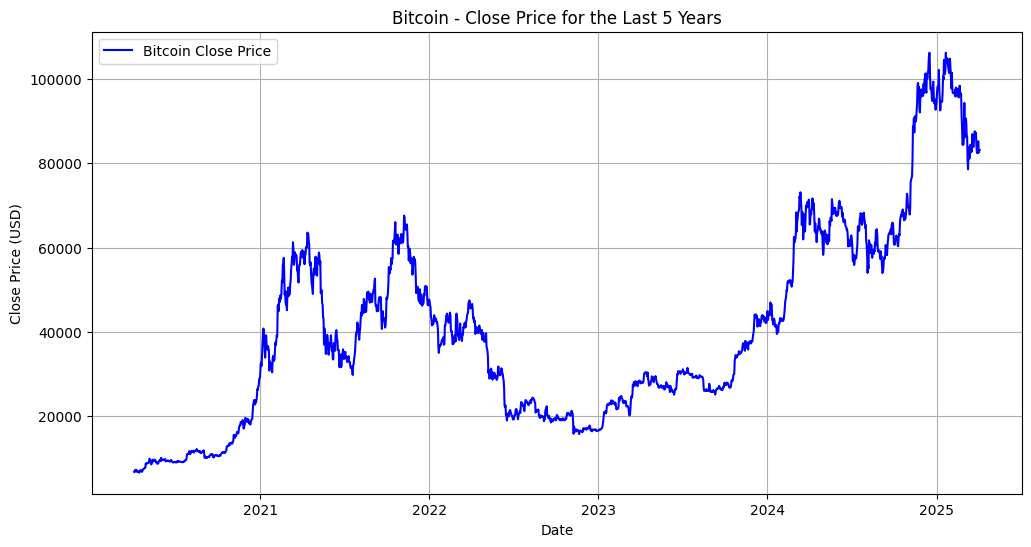

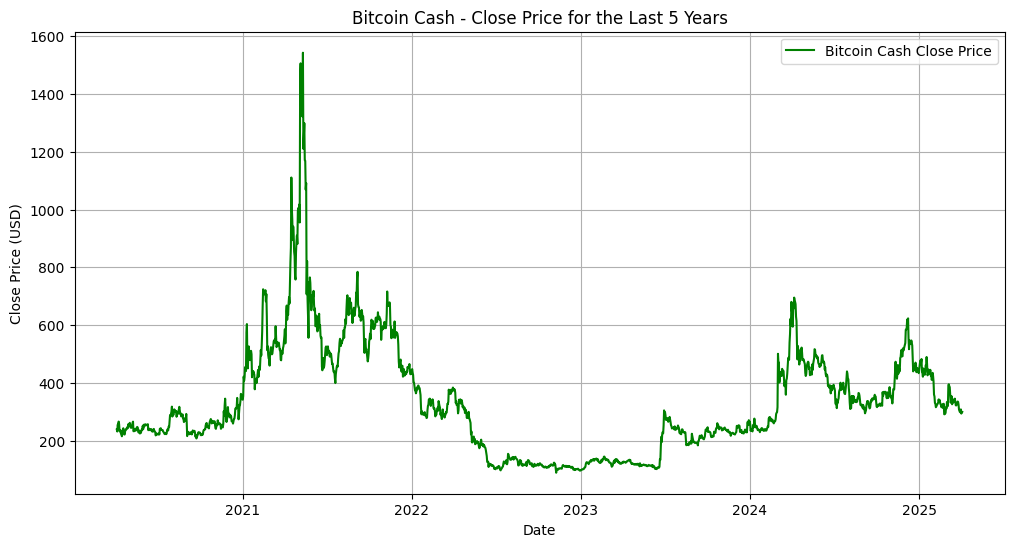

In [159]:
# Plotting closing prices for each day the last 5 years

# Plot for Bitcoin
plt.figure(figsize=(12, 6))
plt.plot(df_Bitcoin.index, df_Bitcoin["Close"], label="Bitcoin Close Price", color="blue")
plt.xlabel("Date")
plt.ylabel("Close Price (USD)")
plt.title("Bitcoin - Close Price for the Last 5 Years")
plt.legend()
plt.grid()
plt.show()

# Plot for Bitcoin Cash
plt.figure(figsize=(12, 6))
plt.plot(df_Bitcoin_Cash.index, df_Bitcoin_Cash["Close"], label="Bitcoin Cash Close Price", color="green")
plt.xlabel("Date")
plt.ylabel("Close Price (USD)")
plt.title("Bitcoin Cash - Close Price for the Last 5 Years")
plt.legend()
plt.grid()
plt.show()


As we want to consider the price spread between bitcoin and bitcoin cash, an important step in the process is to regress the bitcoin cash closing prices onto the bitcoin closing prices with a beta such that the mean spread is 0 for the entirety of the time-series data.

In [160]:
# Add a constant (intercept) to the Bitcoin prices for the regression
X = sm.add_constant(df_Bitcoin['Close'])  # This adds the intercept term to the model
y = df_Bitcoin_Cash['Close']

# Fit the regression model
model = sm.OLS(y, X)
results = model.fit()

# Print the regression summary
print(results.summary())

intercept = results.params[0]
beta = results.params[1]

# Compute the price spread
price_spread = df_Bitcoin_Cash['Close'] - (intercept + beta * df_Bitcoin['Close'])

# Create the new DataFrame
spread_df = pd.DataFrame({'price_spread': price_spread})

# Check results
print(spread_df.head())
print("Mean spread:", spread_df['price_spread'].mean())

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     737.1
Date:                Fri, 04 Apr 2025   Prob (F-statistic):          1.27e-136
Time:                        17:55:21   Log-Likelihood:                -11896.
No. Observations:                1827   AIC:                         2.380e+04
Df Residuals:                    1825   BIC:                         2.381e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        154.0668      7.605     20.258      0.0

C:\Users\tonal\AppData\Local\Temp\ipykernel_27672\2765678762.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = results.params[0]
C:\Users\tonal\AppData\Local\Temp\ipykernel_27672\2765678762.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = results.params[1]


## Empirical Analysis
Stationarity in time-series data means that the statistical properties of the series (such as mean, variance, and autocorrelation) do not change over time. A stationary time series does not have trends, seasonal effects, or other systematic changes over time, making it easier to model and predict. In order to detect non-stationarity in time-series data, we elected to use an Augmented Dickey-Fuller (ADF) test.

The ADF test is used to check whether a time series is stationary by detecting the presence of a unit root. If the time-series data has a unit root, it is non-stationary, meaning its statistical properties change over time. The null hypothesis states that the time-series data has a unit root, meaning it is non-stationary. The alternative hypothesis states that the time series does not have a unit root, meaning it is stationary.

In [161]:
# ADF Test for bitcoin Log return in closing price
adf_btc_c_log_return = adfuller(spread_df['price_spread'].dropna(), maxlag=10, regression='c')
print("\nADF Test for Log return in bitcoin cash closing price:")
print("Test Statistic:", adf_btc_c_log_return[0])
print("p-value:", adf_btc_c_log_return[1])
print("Critical Values:", adf_btc_c_log_return[4])


ADF Test for Log return in bitcoin cash closing price:
Test Statistic: -2.964400293086191
p-value: 0.038355375551913005
Critical Values: {'1%': -3.4339540519343137, '5%': -2.863131988080628, '10%': -2.5676175211639354}


Using an ADF test we notice a p-value of 0.04 for the price spread between the two bitcoin closing prices meaning that we reject the null hypothesis of the price spread having a unit root at a 5% significance level. This implies stationarity in the data meaning it should behave similarly across the course of the data.

Autocorrelation measures the relationship between some time-series data and its lagged values. By considering autocorrelation, one can find patterns and trends in the data that can be further utilized when choosing what forecasting model to use. As an example, ARIMA models depend on autocorrelation structures to make predictions. The Autocorrelation Function (ACF) shows the correlation between some time series and its lagged values at different points in time. This can help us determine trends and seasonality as well as give some insight into how many lags should be included in a forecasting model. The Partial Autocorrelation Function (PACF) has a similar purpose, only that it removes the effects of intermediate lags when considering correlation between current data and some lagged value.

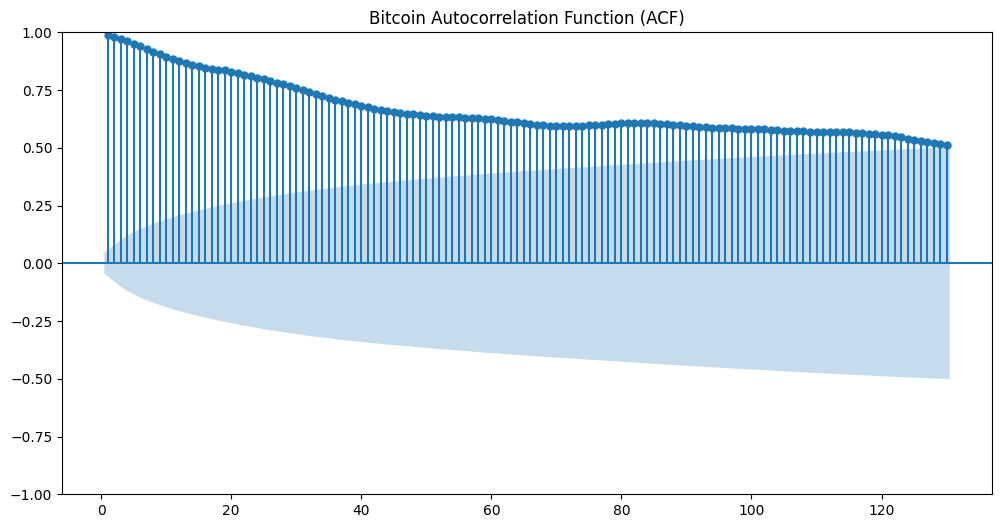

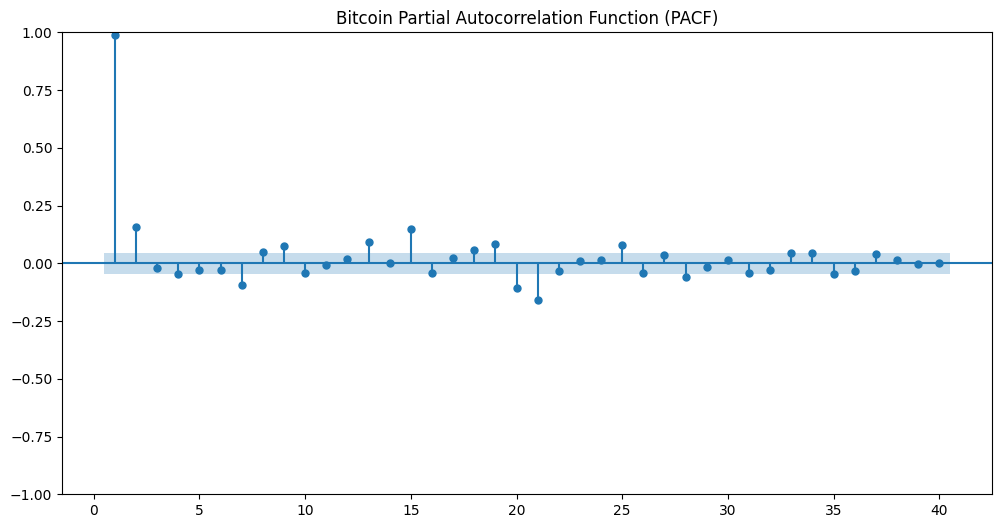

In [166]:
# Plot ACF Bitcoin
plt.figure(figsize=(12,6))
plot_acf(spread_df['price_spread'], lags=130, ax=plt.gca(), zero=False)
plt.title('Bitcoin Autocorrelation Function (ACF)')
plt.show()

# Plot PACF Bitcoin
plt.figure(figsize=(12,6))
plot_pacf(spread_df['price_spread'], lags=40, ax=plt.gca(), zero=False)
plt.title('Bitcoin Partial Autocorrelation Function (PACF)')
plt.show()

Looking at the ACF and PACF of the bitcoin log returns, we see that the first 130 coefficients of the ACF seem to be significant. The coefficients gradually die down in significance, though this is a rather slow process. This likely indicates that there is a trend in the data that can be further utilized when making forecasts. For the PACF, however, only the first two coefficients are significant, with the first coefficient being strongly significant. This suggests that there is some strong autocorrelation in the data that can be utilized to make predictions about future values of the bitcoin price spread.

An Autoregressive Integrated Moving Average (ARIMA) model is a statistical method for time-series forecasting that combines AR and MA models in order to use past values and past forecasting errors to predict future values. Our idea is that by using an ARIMA model, we will be able to utilize autocorrelation and underlying trends in the data to predict future values and thereby make trades based on our predictions.

In [167]:
# Initialize AIC and BIC tables
aic_table = np.full((6, 6), np.nan)
bic_table = np.full((6, 6), np.nan) 

# Fit ARIMA models for different (p, d=0, q) combinations
for ar in range(6):
    for ma in range(6):
        try:
            model = ARIMA(spread_df["price_spread"], order=(ar, 0, ma))
            fitted_model = model.fit()
            print(fitted_model.llf)
            print(fitted_model.df_model)
            aic_table[ar, ma] = fitted_model.aic  
            bic_table[ar, ma] = fitted_model.bic  
        except:
            pass

print("AIC Table:\n", aic_table)
print("\nBIC Table:\n", bic_table)

# Find the (p, q) combination with the lowest AIC
min_aic_index = np.unravel_index(np.nanargmin(aic_table), aic_table.shape)
min_bic_index = np.unravel_index(np.nanargmin(bic_table), bic_table.shape)

print(f"\nBest ARMA(p,q) for AIC: p={min_aic_index[0]}, q={min_aic_index[1]}")
print(f"Best ARMA(p,q) for BIC: p={min_bic_index[0]}, q={min_bic_index[1]}")

C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


-11895.606147705887
2


C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


-10835.002525931772
3


C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


-10159.411790583472
4


C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


-9699.99786233727
5


C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


-9402.975805864171
6


C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\b

-9247.381898867778
7
-8455.93210367809
3
-8432.530591902781
4


C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


-8429.541457822306
5


C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


-8428.014853123066
6


C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


-8426.721457837757
7


C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


-8423.825533468022
8


C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


-8430.74729482392
4


C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


-8430.592249306043
5


C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


-8425.43696637586
6


C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packa

-8424.799162913956
7


C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


-8424.498257984045
8


C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


-8422.665409457783
9


C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


-8430.502191976506
5


C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


-8430.70816934666
6


C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


-8424.69673446631
7


C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packa

-8411.622078291864
8


C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


-8409.660302559332
9


C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


-8407.937410368479
10
-8428.255113576
6


C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


-8425.773954508764
7


C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packa

-8411.00601842281
8


C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


-8415.429352653788
9


C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


-8412.426688128184
10


C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


-8401.184392708426
11
-8427.250266823557
7


C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


-8426.965544862542
8


C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\t

-8425.410005493275
9


C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


-8410.520908914978
10


C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


-8401.633873276973
11
-8401.173198726163
12
AIC Table:
 [[23795.21229541 21676.00505186 20326.82358117 19409.99572467
  18817.95161173 18508.76379774]
 [16917.86420736 16873.06118381 16869.08291564 16868.02970625
  16867.44291568 16863.65106694]
 [16869.49458965 16871.18449861 16862.87393275 16863.59832583
  16864.99651597 16863.33081892]
 [16871.00438395 16873.41633869 16863.39346893 16839.24415658
  16837.32060512 16835.87482074]
 [16868.51022715 16865.54790902 16838.01203685 16848.85870531
  16844.85337626 16824.36878542]
 [16868.50053365 16869.93108973 16868.82001099 16841.04181783
  16825.26774655 16826.34639745]]

BIC Table:
 [[23806.23315652 21692.53634353 20348.86530339 19437.54787746
  18851.01419507 18547.33681163]
 [16934.39549903 16895.10290603 16896.63506843 16901.09228958
  16906.01592957 16907.73451139]
 [16891.53631187 16898.73665139 16895.93651609 16902.17133972
  16909.07996042 16912.92469392]
 [16898.55653673 16906.47892203 16901.96648283 16883.32760103
  16886.91448

C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Now that we have established the stationarity of the data and the presence of autocorrelation, we move on to the model that will be used to make predictions about the data. In order to find the best performing number of lags, all ARIMA models with p and q from 0 to 6 individually were trained. Thereafter, the information criteria AIC and SBIC were used to determine which model best suited the purpose of the experiment. The AIC and SBIC information criteria each gave a different model with AIC suggesting ARIMA(4,5) and SBIC suggesting ARIMA(4,2). SBIC is generally a more consistent information criterion and by comparing the performances of the suggested models, we were able to verify that an ARIMA(4,2) model would best suit our needs. As such, we moved on to making predictions using the ARIMA(4,2) model.

When making forecasts, one has the option between dynamic and static forecasting. Dynamic forecasting revolves around using previously forecasted values when making new forecasts while static forecasting is a multi-stage forecast where the same values are used to multiple future values. For our purposes, we elected to use a dynamic forecasting approach as this would better mimic the the way bitcoin prices move in reality.

In [178]:
np.random.seed(25)
forecast_steps = 10
forecasts = []

for i in range(0, 140):
    spread_estimation = spread_df["price_spread"].iloc[:-150+i]  # Exclude the last 150 days for testing
    btc_model = ARIMA(spread_estimation, order=(4, 0, 2))
    fitted_btc_model = btc_model.fit()
    forecast = fitted_btc_model.forecast(steps=forecast_steps)
    forecasts.append(forecast[-1])

C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tonal\AppData\Roaming\Python\Python311\site-packa

## Trading Trial

Forecasts:  140
Spread trading:  140
Cumulative perfect trading signal:  5401.035230561838
Cumulative profit:  -205.4095669276379
Final profit:  -205.4095669276379


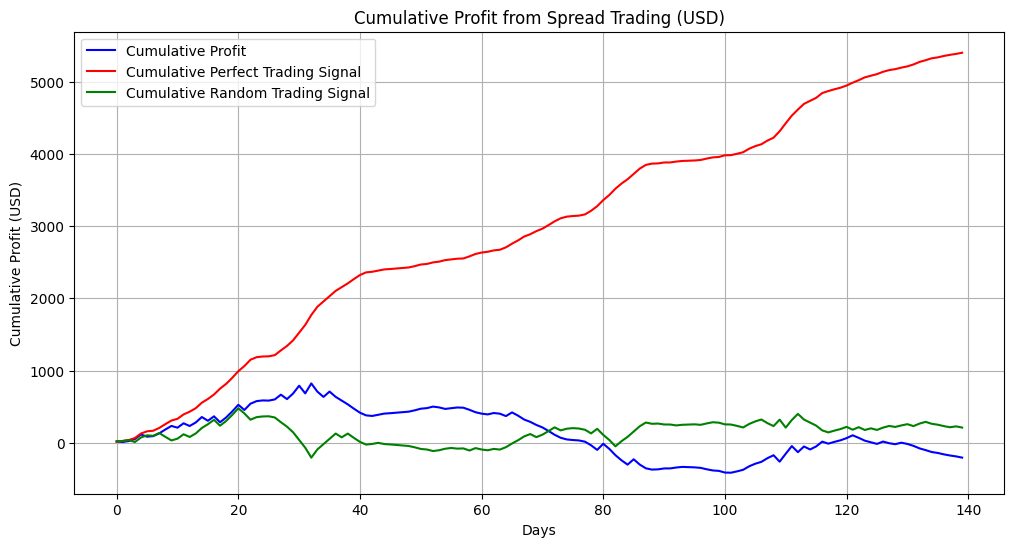

In [179]:
np.random.seed(10)
spread_trading = spread_df["price_spread"].iloc[-150:-10]  # Last 150 days for testing
trade_results = spread_df["price_spread"].iloc[-140:]  # Last 150 days for testing

print("Forecasts: ", len(forecasts))
print("Spread trading: ", len(spread_trading))

# List, 1 for buy, -1 for sell, 0 for hold if forecasts[i] > spread_trading.iloc[i] else -1
trading_signal = []
for i in range(len(forecasts)):
    if forecasts[i] > spread_trading.iloc[i]:
        trading_signal.append(1)  # Buy
    elif forecasts[i] < spread_trading.iloc[i]:
        trading_signal.append(-1)  # Sell
    else:
        trading_signal.append(0)  # Hold

spread_movement = np.array(trade_results) - np.array(spread_trading)
perfect_trading_signal = np.abs(spread_movement)
cumulative_perfect_trading_signal = np.cumsum(perfect_trading_signal)
print("Cumulative perfect trading signal: ", cumulative_perfect_trading_signal[-1])
random_trading_signal = np.random.choice([-1, 1], size=len(trading_signal), p=[0.5, 0.5])
random_trading_signal_profit = random_trading_signal * spread_movement
cumulative_random_trading_signal = np.cumsum(random_trading_signal_profit)

trading_profit = trading_signal * spread_movement
cumulative_profit = np.cumsum(trading_profit)
print("Cumulative profit: ", cumulative_profit[-1])
print("Final profit: ", cumulative_profit[-1])
plt.figure(figsize=(12, 6))
plt.plot(cumulative_profit, label="Cumulative Profit", color="blue")
plt.plot(cumulative_perfect_trading_signal, label="Cumulative Perfect Trading Signal", color="red")
plt.plot(cumulative_random_trading_signal, label="Cumulative Random Trading Signal", color="green")
plt.xlabel("Days")
plt.ylabel("Cumulative Profit (USD)")
plt.title("Cumulative Profit from Spread Trading (USD)")
plt.legend()
plt.grid()
plt.show()
# Calculate performance metrics
mse = mean_squared_error(trade_results, forecasts)
mae = mean_absolute_error(trade_results, forecasts)
mape = mean_absolute_percentage_error(trade_results, forecasts)



## Conclusion

This analysis evaluates a spread trading strategy using an ARIMA-based forecast model over **140 trading days**. The strategy's performance is benchmarked against a **perfect foresight strategy** and a **random signal baseline**.

---

### Results

- **Number of forecasts:** 140  
- **Cumulative profit (Perfect Trading Signal):** \$5,398.99  
- **Cumulative profit (Forecast-Based Strategy):** **- \$205.41**  


---

### Strategy Comparison

| Strategy                      | Cumulative Profit (USD) | Performance Summary                                             |
|------------------------------|--------------------------|------------------------------------------------------------------|
| 🔴 Perfect Trading Signal     | \$5,398.99               | Ideal scenario with future knowledge – sets the upper benchmark. |
| 🔵 Forecast-Based Strategy    | - \$205.41        | Model underperforms slightly; potential for improvement.     |
| 🟢 Random Trading Signal      | ~Flat                    | Serves as a noise-level baseline; outperformed the model here.    |

---

### Insights

- The ARIMA model underperformed, especially after day 40, suggesting forecast decay or misalignment with spread dynamics.
- The ARIMA model performed quite similar to a random walk process, represented by the green graph.
- The large gap between perfect foresight and actual performance implies room for model improvement.
- Possible next steps:
  - Introduce volatility filters or signal thresholds
  - Use walk-forward retraining
  - Explore machine learning or regime-switching models

---

The current ARIMA-based strategy does not generate profitable trading signals in this setting. Enhancing the model’s ability to capture the underlying spread behavior will be essential for real-world deployment. Despite what appeared to be trends in the data and autocorrelation that could be utilized when making predictions, it seems that the linear approach of an ARIMA model was unable to make profitable trades. This suggests that further exploration into both the data and alternative strategies would be necessary.


## Use of LLMs

The group generally did not rely on LLMs except for smaller tasks where LLM usage increased work efficiency. This usage consisted of utilizing ChatGPT for smaller tasks such as code debugging, grammar and spell checking and language simplification and clarification.